## **Preparations**

In [129]:
import time
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import sklearn.datasets as ds
import sklearn.model_selection as cv
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    VotingClassifier,    
)

%matplotlib inline

In [2]:
#initializing stuff

# Load dataset
diabetes_df = pd.read_csv('../preprocessing_scripts/Data_preprocessed_10000.csv')
X, y = diabetes_df.drop(columns="Diabetes_binary"), diabetes_df["Diabetes_binary"]

print(X)
print(y)

#creating a test-train spilt

(X_train, X_test,  y_train, y_test) = cv.train_test_split(X, y, test_size = .3, random_state = 42)

#creating the stratified k-fold object to be used

SKFold = cv.StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

      HighBP  HighChol  CholCheck       BMI  Smoker  Stroke  \
0        0.0       1.0        1.0 -1.071593     1.0     0.0   
1        0.0       0.0        1.0  0.628607     1.0     0.0   
2        1.0       1.0        1.0 -0.319133     1.0     0.0   
3        0.0       1.0        1.0  0.017644     1.0     0.0   
4        1.0       0.0        1.0  2.311887     0.0     0.0   
...      ...       ...        ...       ...     ...     ...   
9934     0.0       0.0        1.0 -0.319133     1.0     0.0   
9935     1.0       1.0        1.0  1.041359     1.0     0.0   
9936     1.0       1.0        1.0  0.177702     0.0     0.0   
9937     0.0       0.0        1.0 -1.723404     0.0     0.0   
9938     1.0       1.0        1.0 -1.279341     0.0     0.0   

      HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  ...  AnyHealthcare  \
0                      0.0           1.0     0.0      1.0  ...            1.0   
1                      0.0           0.0     1.0      1.0  ...            1.0   


In [3]:
# Define a function to measure execution's time. It will be use as a 'decorator'
# The idea behind this is just to use it to estimate the time it will take for the
# full code to run if you want to know before training with the complete dataset
# using a subset of size known in relationship with the full dataset.
def compute_executions_time(function):
    def wrapper():
        start_time = time.time()  # init measuring time
        result = function()  # execute function
        print(f"\n{time.time() - start_time} seconds")  # print execution time
        return result
    return wrapper

In [ ]:
def make_roc(classifier):
    y_scores = classifier.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [ ]:
def plot_f1_scores_vs_parameter(parameter,parameter_list, scores_list, std_dev_list):
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        parameter_list,
        scores_list,
        yerr=std_dev_list,
        fmt='-o',
        ecolor='gray',
        elinewidth=1,
        capsize=3,
        label='Mean F1 Score ± Std'
    )
    plt.title(f"F1 Score vs {parameter} (with Standard Deviation)")
    plt.xlabel(f"{parameter}")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def compare_classifiers_mcnemar(classifier1, classifier2):
    # Make predictions
    pred1 = classifier1.predict(X_test)
    pred2 = classifier2.predict(X_test)

    # Accuracy (optional, just to see basic performance)
    acc1 = f1_score(y_test, pred1)
    acc2 = f1_score(y_test, pred2)
    print(f"Classifier 1 F1-score: {acc1:.4f}")
    print(f"Classifier 2 F1-score: {acc2:.4f}")

    # Create 2x2 contingency table
    b = np.sum((pred1 == y_test) & (pred2 != y_test))  # classifier1 correct, classifier2 wrong
    c = np.sum((pred1 != y_test) & (pred2 == y_test))  # classifier1 wrong, classifier2 correct

    table = [[0, b],
             [c, 0]]  # only b and c matter for McNemar

    # McNemar test
    result = mcnemar(table)

    print("\nMcNemar Test Results:")
    print(f"Statistic: {result.statistic}")
    print(f"P-value  : {result.pvalue:.5f}")

    # Interpret result
    alpha = 0.05
    if result.pvalue < alpha:
        print("There is a statistically significant difference between the classifiers.")
    else:
        print("There is no evidence of significant difference between the classifiers.")


## **Random Forest**

              precision    recall  f1-score   support

         0.0       0.75      0.68      0.72      1526
         1.0       0.70      0.77      0.73      1456

    accuracy                           0.72      2982
   macro avg       0.72      0.72      0.72      2982
weighted avg       0.73      0.72      0.72      2982



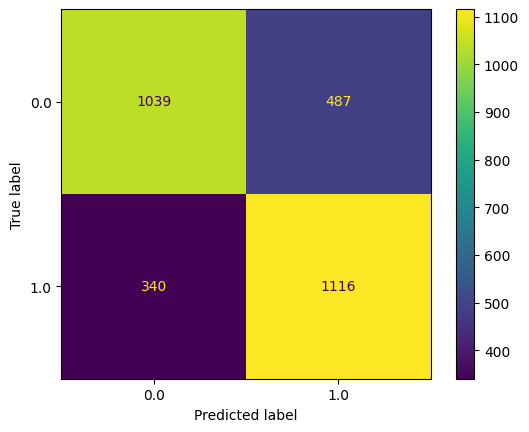

In [4]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test,predictions)

F1-score: 0.65388 [nº estimators (trees): 1]
F1-score: 0.56828 [nº estimators (trees): 2]
F1-score: 0.68997 [nº estimators (trees): 3]
F1-score: 0.65249 [nº estimators (trees): 4]
F1-score: 0.70576 [nº estimators (trees): 5]
F1-score: 0.68738 [nº estimators (trees): 6]
F1-score: 0.71986 [nº estimators (trees): 7]
F1-score: 0.70058 [nº estimators (trees): 8]
F1-score: 0.72375 [nº estimators (trees): 9]
F1-score: 0.71033 [nº estimators (trees): 10]
F1-score: 0.73139 [nº estimators (trees): 11]
F1-score: 0.71478 [nº estimators (trees): 12]
F1-score: 0.73198 [nº estimators (trees): 13]
F1-score: 0.71976 [nº estimators (trees): 14]
F1-score: 0.73572 [nº estimators (trees): 15]
F1-score: 0.72277 [nº estimators (trees): 16]
F1-score: 0.73487 [nº estimators (trees): 17]
F1-score: 0.72572 [nº estimators (trees): 18]
F1-score: 0.73801 [nº estimators (trees): 19]
F1-score: 0.73105 [nº estimators (trees): 20]
F1-score: 0.73909 [nº estimators (trees): 21]
F1-score: 0.73267 [nº estimators (trees): 2

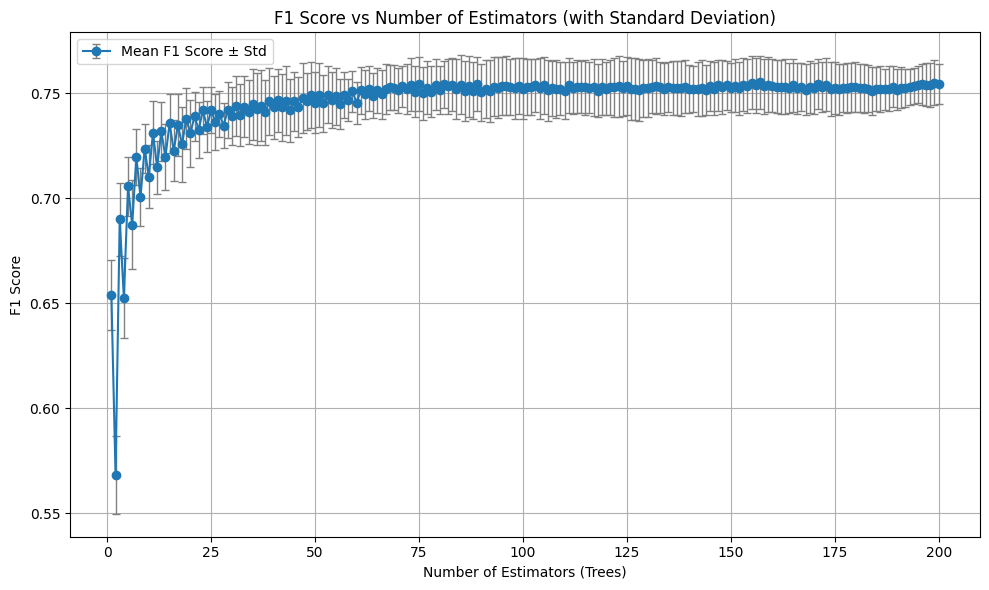

In [ ]:
@compute_executions_time
def execute_random_forest_with_different_estimators():
    parameter_list = []
    scores_list = []
    std_dev_list = []

    for n_trees in range(1, 201):
        random_forest_classifier = RandomForestClassifier(
            n_estimators=n_trees,
            random_state=42
        )
        scores = cross_val_score(
            estimator=random_forest_classifier,
            X=X_train,
            y=y_train,
            cv=SKFold,
            scoring="f1",
            n_jobs=-1
        )
        mean_score = scores.mean()
        std_dev_score = scores.std()
        print(f"F1-score: {mean_score:.5f} [nº estimators (trees): {n_trees}]")

        parameter_list.append(n_trees)
        scores_list.append(mean_score)
        std_dev_list.append(std_dev_score)

    return parameter_list, scores_list, std_dev_list


In [ ]:
parameter_list, scores_list, std_dev_list = execute_random_forest_with_different_estimators()
plot_f1_scores_vs_parameter("n_estimators",parameter_list, scores_list, std_dev_list)

NameError: name 'execute_random_forest_with_different_estimators' is not defined

In [ ]:
#testing statistical difference between n_estimators=75 and n_estimators=200
rf1 = RandomForestClassifier(n_estimators=200,random_state=42)
rf2 = RandomForestClassifier(n_estimators=75,random_state=42)
rf1.fit(X_train, y_train)
rf2.fit(X_train, y_train)
compare_classifiers_mcnemar(rf1,rf2)

Classifier 1 F1-score: 0.7297
Classifier 2 F1-score: 0.7361

McNemar Test Results:
Statistic: 24.0
P-value  : 0.05994
There is no evidence of significant difference between the classifiers.


              precision    recall  f1-score   support

         0.0       0.76      0.68      0.72      1526
         1.0       0.70      0.78      0.74      1456

    accuracy                           0.73      2982
   macro avg       0.73      0.73      0.73      2982
weighted avg       0.73      0.73      0.73      2982



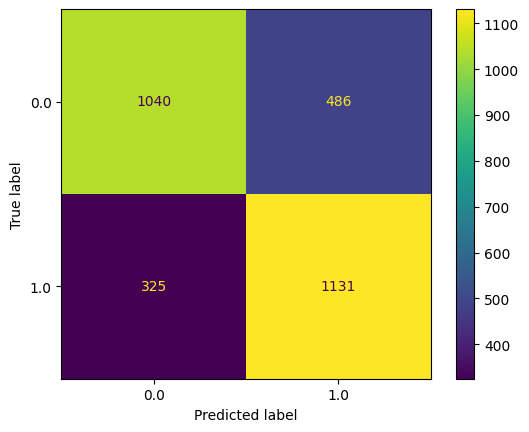

In [57]:
rf = RandomForestClassifier(n_estimators=75, random_state=42)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test,predictions)

In [12]:
#determinacion de mejor combinación de n_estimators y max_features con GridSearch

params = {
    "n_estimators" : range(1,201,10),
    "max_features": ["sqrt", "log2", 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
}

clf = GridSearchCV(estimator=RandomForestClassifier(),
            param_grid=params,
            scoring="f1",
            n_jobs=-1,
            cv=SKFold
            )
clf.fit(X_train,y_train)

print(clf.best_params_)
best_n_trees_rf = clf.best_params_["n_estimators"]
best_max_features_rf = clf.best_params_["max_features"]
print(clf.best_score_)

{'max_features': 0.1, 'n_estimators': 91}
0.7588589561689033


              precision    recall  f1-score   support

         0.0       0.76      0.68      0.72      1526
         1.0       0.70      0.77      0.73      1456

    accuracy                           0.73      2982
   macro avg       0.73      0.73      0.73      2982
weighted avg       0.73      0.73      0.73      2982



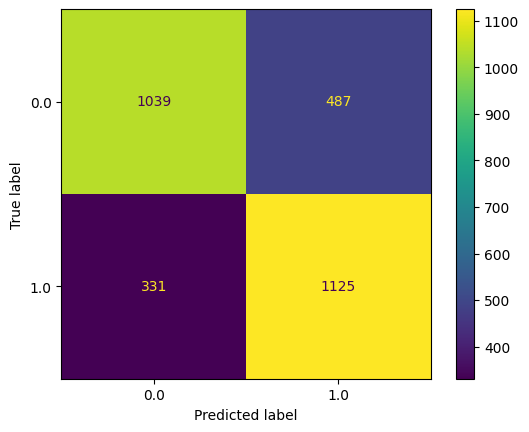

In [14]:
predictions = clf.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test,predictions)

In [58]:
#testing statistical difference between n_estimators=75 and n_estimators=181+max_features="log2"
rf1 = RandomForestClassifier(n_estimators=75,random_state=42)
rf1.fit(X_train, y_train)
compare_classifiers_mcnemar(rf1,clf.best_estimator_)

Classifier 1 F1-score: 0.7361
Classifier 2 F1-score: 0.7334

McNemar Test Results:
Statistic: 97.0
P-value  : 0.67225
There is no evidence of significant difference between the classifiers.


In [59]:
#determinación de mejor criterion

for criteria in ["gini", "entropy", "log_loss"]:
        random_forest_classifier = RandomForestClassifier(
            criterion = criteria
        )
        scores = cross_val_score(
            estimator = random_forest_classifier,
            X = X_train,
            y = y_train,
            cv=SKFold,
            scoring="f1",
            n_jobs=-1
        )

        print(f"F1-score: {scores.mean():.5f} [criterion: {criteria}]")


F1-score: 0.75155 [criterion: gini]
F1-score: 0.74823 [criterion: entropy]
F1-score: 0.75417 [criterion: log_loss]


In [61]:
#testing statistical difference between default and criterion="log_loss"
rf1 = RandomForestClassifier(random_state=42)
rf2 = RandomForestClassifier(criterion="log_loss",random_state=42)
rf1.fit(X_train, y_train)
rf2.fit(X_train, y_train)
compare_classifiers_mcnemar(rf1,rf2)

Classifier 1 F1-score: 0.7297
Classifier 2 F1-score: 0.7374

McNemar Test Results:
Statistic: 70.0
P-value  : 0.09866
There is no evidence of significant difference between the classifiers.


In [62]:
#testing statistical difference between default and criterion="entropy"
rf1 = RandomForestClassifier(random_state=42)
rf2 = RandomForestClassifier(criterion="entropy",random_state=42)
rf1.fit(X_train, y_train)
rf2.fit(X_train, y_train)
compare_classifiers_mcnemar(rf1,rf2)

Classifier 1 F1-score: 0.7297
Classifier 2 F1-score: 0.7374

McNemar Test Results:
Statistic: 70.0
P-value  : 0.09866
There is no evidence of significant difference between the classifiers.


In [20]:
#determinación de mejor max_depth

for depth in [None, 5,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40,45,50]:
        random_forest_classifier = RandomForestClassifier(
            max_depth = depth
        )
        scores = cross_val_score(
            estimator = random_forest_classifier,
            X = X_train,
            y = y_train,
            cv=SKFold,
            scoring="f1",
            n_jobs=-1
        )

        print(f"F1-score: {scores.mean():.5f} [max_depth: {depth}]")

F1-score: 0.74982 [max_depth: None]
F1-score: 0.75583 [max_depth: 5]
F1-score: 0.75972 [max_depth: 10]
F1-score: 0.75914 [max_depth: 11]
F1-score: 0.75554 [max_depth: 12]
F1-score: 0.75864 [max_depth: 13]
F1-score: 0.75708 [max_depth: 14]
F1-score: 0.75432 [max_depth: 15]
F1-score: 0.75224 [max_depth: 16]
F1-score: 0.75267 [max_depth: 17]
F1-score: 0.75184 [max_depth: 18]
F1-score: 0.75376 [max_depth: 19]
F1-score: 0.75378 [max_depth: 20]
F1-score: 0.74781 [max_depth: 25]
F1-score: 0.74747 [max_depth: 30]
F1-score: 0.75027 [max_depth: 35]
F1-score: 0.75600 [max_depth: 40]
F1-score: 0.74754 [max_depth: 45]
F1-score: 0.75619 [max_depth: 50]


In [81]:
#testing statistical difference between default and max_depth=10
rf1 = RandomForestClassifier(random_state=42)
rf2 = RandomForestClassifier(max_depth=11,random_state=42)
rf1.fit(X_train, y_train)
rf2.fit(X_train, y_train)
compare_classifiers_mcnemar(rf1,rf2)

Classifier 1 F1-score: 0.7297
Classifier 2 F1-score: 0.7413

McNemar Test Results:
Statistic: 80.0
P-value  : 0.03511
There is a statistically significant difference between the classifiers.


In [ ]:
#testing statistical difference between dafault and max_depth=10
rf1 = RandomForestClassifier(n_estimators=75,random_state=42)
rf2 = RandomForestClassifier(max_depth=11,random_state=42)
rf1.fit(X_train, y_train)
rf2.fit(X_train, y_train)
compare_classifiers_mcnemar(rf1,rf2)

Classifier 1 F1-score: 0.7413
Classifier 2 F1-score: 0.7334

McNemar Test Results:
Statistic: 89.0
P-value  : 0.15609
There is no evidence of significant difference between the classifiers.


## **Bagging**

              precision    recall  f1-score   support

         0.0       0.70      0.71      0.71      1526
         1.0       0.69      0.69      0.69      1456

    accuracy                           0.70      2982
   macro avg       0.70      0.70      0.70      2982
weighted avg       0.70      0.70      0.70      2982



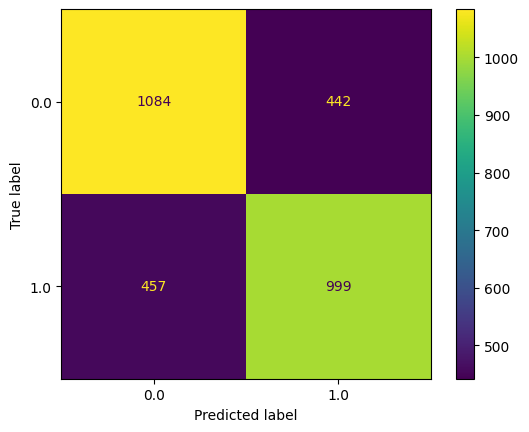

In [24]:
bg = BaggingClassifier(random_state=42)
bg.fit(X_train, y_train)
predictions = bg.predict(X_test)
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test,predictions)

In [ ]:
# determinación de valores de n_estimators
@compute_executions_time
def execute_bagging_with_different_estimators():
    parameter_list = []
    scores_list = []
    std_dev_list = []
    for nest in range(1,201,1):
        scores = cross_val_score(
            BaggingClassifier(
                estimator = DecisionTreeClassifier(),
                n_estimators = nest
            ), 
            X_train, 
            y_train, 
            cv = SKFold, 
            scoring="f1",
            n_jobs=-1
        )
        mean_score = scores.mean()
        std_dev_score = scores.std()
        print(f"F1-score: {mean_score:.5f} [nº estimators (trees): {nest}]")

        parameter_list.append(nest)
        scores_list.append(mean_score)
        std_dev_list.append(std_dev_score)

    return parameter_list, scores_list, std_dev_list

In [ ]:
parameter_list, scores_list, std_dev_list = execute_bagging_with_different_estimators()
plot_f1_scores_vs_parameter("n_estimators",parameter_list, scores_list, std_dev_list)

F1-score: 0.65449 [nº estimators (trees): 1]
F1-score: 0.55747 [nº estimators (trees): 2]
F1-score: 0.68431 [nº estimators (trees): 3]
F1-score: 0.65355 [nº estimators (trees): 4]
F1-score: 0.70198 [nº estimators (trees): 5]
F1-score: 0.67943 [nº estimators (trees): 6]
F1-score: 0.70977 [nº estimators (trees): 7]
F1-score: 0.69181 [nº estimators (trees): 8]
F1-score: 0.71910 [nº estimators (trees): 9]
F1-score: 0.69937 [nº estimators (trees): 10]
F1-score: 0.72460 [nº estimators (trees): 11]
F1-score: 0.71103 [nº estimators (trees): 12]
F1-score: 0.72359 [nº estimators (trees): 13]
F1-score: 0.71646 [nº estimators (trees): 14]
F1-score: 0.72427 [nº estimators (trees): 15]
F1-score: 0.71269 [nº estimators (trees): 16]
F1-score: 0.72928 [nº estimators (trees): 17]


KeyboardInterrupt: 

In [36]:
#testing statistical difference between n_estimators=75 and n_estimators=200
bg1 = BaggingClassifier(n_estimators=75,random_state=42)
bg2 = BaggingClassifier(n_estimators=200,random_state=42)
bg1.fit(X_train, y_train)
bg2.fit(X_train, y_train)
compare_classifiers_mcnemar(bg1,bg2)

Classifier 1 F1-score: 0.7243
Classifier 2 F1-score: 0.7291

McNemar Test Results:
Statistic: 54.0
P-value  : 0.45969
There is no evidence of significant difference between the classifiers.


              precision    recall  f1-score   support

         0.0       0.75      0.67      0.71      1526
         1.0       0.69      0.76      0.72      1456

    accuracy                           0.72      2982
   macro avg       0.72      0.72      0.72      2982
weighted avg       0.72      0.72      0.72      2982



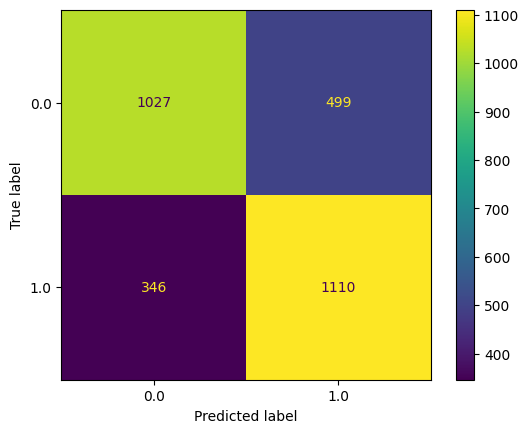

In [28]:
bg = BaggingClassifier(n_estimators=75,random_state=42)
bg.fit(X_train, y_train)
predictions = bg.predict(X_test)
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test,predictions)

In [92]:
# determinación de valores de max_samples

def execute_bagging_with_different_samples():
    parameter_list = []
    scores_list = []
    std_dev_list = []
    for max in [0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00]:
        scores = cross_val_score(
            BaggingClassifier(
                estimator = DecisionTreeClassifier(),
                max_samples = max
            ), 
            X_train, 
            y_train, 
            cv = SKFold, 
            scoring="f1",
            n_jobs=-1
        )
        mean_score = scores.mean()
        std_dev_score = scores.std()
        print(f"F1-score: {mean_score:.5f} [max_samples: {max}]")

        parameter_list.append(max)
        scores_list.append(mean_score)
        std_dev_list.append(std_dev_score)

    return parameter_list, scores_list, std_dev_list

F1-score: 0.71219 [max_samples: 0.05]
F1-score: 0.70791 [max_samples: 0.1]
F1-score: 0.71285 [max_samples: 0.15]
F1-score: 0.71627 [max_samples: 0.2]
F1-score: 0.71207 [max_samples: 0.25]
F1-score: 0.70218 [max_samples: 0.3]
F1-score: 0.70537 [max_samples: 0.35]
F1-score: 0.70774 [max_samples: 0.4]
F1-score: 0.70399 [max_samples: 0.45]
F1-score: 0.70664 [max_samples: 0.5]
F1-score: 0.70306 [max_samples: 0.55]
F1-score: 0.70408 [max_samples: 0.6]
F1-score: 0.70373 [max_samples: 0.65]
F1-score: 0.70566 [max_samples: 0.7]
F1-score: 0.70055 [max_samples: 0.75]
F1-score: 0.70835 [max_samples: 0.8]
F1-score: 0.69012 [max_samples: 0.85]
F1-score: 0.69866 [max_samples: 0.9]
F1-score: 0.69695 [max_samples: 0.95]
F1-score: 0.70544 [max_samples: 1.0]


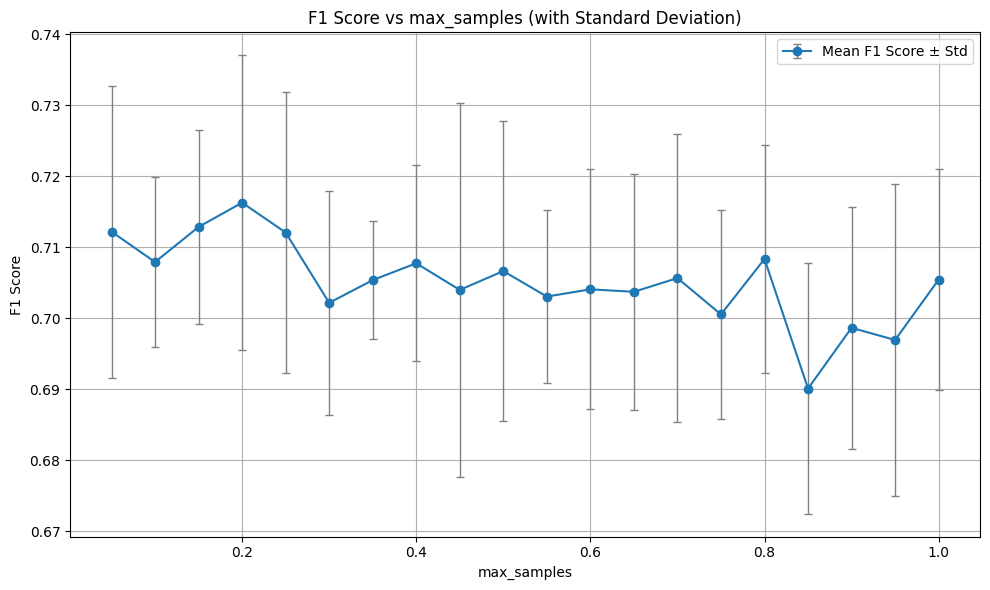

In [93]:
parameter_list, scores_list, std_dev_list = execute_bagging_with_different_samples()
plot_f1_scores_vs_parameter("max_samples",parameter_list, scores_list, std_dev_list)

In [ ]:
#testing statistical difference between default and max_samples=0.2
bg1 = BaggingClassifier(random_state=42)
bg2 = BaggingClassifier(max_samples=0.2,random_state=42)
bg1.fit(X_train, y_train)
bg2.fit(X_train, y_train)
compare_classifiers_mcnemar(bg1,bg2)

Classifier 1 F1-score: 0.6897
Classifier 2 F1-score: 0.6887

McNemar Test Results:
Statistic: 272.0
P-value  : 0.83119
There is no evidence of significant difference between the classifiers.


In [95]:
# determinación de valores de max_features
for max in [0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00]:
    scores = cross_val_score(
        BaggingClassifier(
            estimator = DecisionTreeClassifier(),
            max_features= max
        ), 
        X_train, 
        y_train, 
        cv = SKFold, 
        scoring="f1",
        n_jobs=-1
    )
    print(f"F1-score: {scores.mean():.5f} [max_features: {max}]")

F1-score: 0.67911 [max_features: 0.05]
F1-score: 0.70069 [max_features: 0.1]
F1-score: 0.72315 [max_features: 0.15]
F1-score: 0.73250 [max_features: 0.2]
F1-score: 0.72688 [max_features: 0.25]
F1-score: 0.72491 [max_features: 0.3]
F1-score: 0.71226 [max_features: 0.35]
F1-score: 0.71295 [max_features: 0.4]
F1-score: 0.72333 [max_features: 0.45]
F1-score: 0.71725 [max_features: 0.5]
F1-score: 0.71149 [max_features: 0.55]
F1-score: 0.70685 [max_features: 0.6]
F1-score: 0.71334 [max_features: 0.65]
F1-score: 0.70514 [max_features: 0.7]
F1-score: 0.70195 [max_features: 0.75]
F1-score: 0.70746 [max_features: 0.8]
F1-score: 0.70376 [max_features: 0.85]
F1-score: 0.70434 [max_features: 0.9]
F1-score: 0.70014 [max_features: 0.95]
F1-score: 0.69835 [max_features: 1.0]


In [96]:
#testing statistical difference between default and max_features=0.2
bg1 = BaggingClassifier(random_state=42)
bg2 = BaggingClassifier(max_features=0.2,random_state=42)
bg1.fit(X_train, y_train)
bg2.fit(X_train, y_train)
compare_classifiers_mcnemar(bg1,bg2)

Classifier 1 F1-score: 0.6897
Classifier 2 F1-score: 0.6977

McNemar Test Results:
Statistic: 336.0
P-value  : 0.75920
There is no evidence of significant difference between the classifiers.


## **Extra Trees Classifier**

In [ ]:
@compute_executions_time
def execute_extra_trees_classifier_with_different_estimators_and_cv(cv=10):
    for n_trees in [1, 2, 5, 10, 20, 50, 100, 200]:
        extra_trees_classifier = ExtraTreesClassifier(
            n_estimators = n_trees
        )
        scores = cross_val_score(
            estimator = extra_trees_classifier,
            X = X,
            y = y,
            cv = cv,
            scoring = "f1",
            n_jobs=-1
        )
        print(f"F1-score: {scores.mean():.3f} [nº estimators (trees): {n_trees}]")

execute_extra_trees_classifier_with_different_estimators_and_cv()

## **Voting Scheme**

In [108]:
k_neighbors = KNeighborsClassifier()
params_space = {
    "n_neighbors": list(range(1, 101, 1)),
    "weights": ["distance", "uniform"]
}    
#search for best metaparameters for knn
clf = GridSearchCV(
    k_neighbors, 
    scoring="f1",
    param_grid = params_space,
    cv = SKFold,
    n_jobs = -1
)
clf.fit(X_train, y_train)
best_parameters_for_knn = clf.best_params_
print(f"Best Params fo Knn: {clf.best_params_} - f1-score: {clf.best_score_}")

knn = KNeighborsClassifier(
    n_neighbors = best_parameters_for_knn["n_neighbors"],
    weights = best_parameters_for_knn["weights"]
)

Best Params fo Knn: {'n_neighbors': 74, 'weights': 'distance'} - f1-score: 0.7433152342641025


In [109]:
@compute_executions_time
def execute_voting_scheme_different_estimators_grid_search():
    naive_bayes = GaussianNB()

    clf3 = DecisionTreeClassifier(criterion="gini", max_depth=4, min_samples_leaf=1)

    for clf, label in zip([naive_bayes, knn, clf3], ["Naive Bayes","Knn", "Dec. Tree", ]):
        scores = cross_val_score(
            clf, 
            X_train, 
            y_train, 
            cv = SKFold, 
            n_jobs=-1,
            scoring = "f1"
        )
        print(f"F1-score: {scores.mean():.5f} [{label}]")

    warnings.filterwarnings("ignore", category=DeprecationWarning)  # Just to avoid warnings

    voting_classifier = VotingClassifier(
        estimators=[
            ("nb", naive_bayes),
            ("knn", knn),
            ("dt", clf3)
        ],
        voting = "hard"
    )
    scores = cross_val_score(
        voting_classifier,
        X_train,
        y_train,
        cv = SKFold,
        n_jobs=-1,
        scoring = "f1")
    print("F1-score: %0.3f [%s]" % (scores.mean() , f"Majority Voting with hard voting"))

    for w in [[0.66,0.167,0.166], [0.167,0.66,0.166], [0.167,0.166,0.66]]:
        voting_classifier = VotingClassifier(
            estimators=[
                ("nb", naive_bayes),
                ("knn3", knn),
                ("dt", clf3)
            ],
            voting = "soft",
            weights=w
        )
        scores = cross_val_score(
            voting_classifier,
            X_train,
            y_train,
            cv = SKFold,
            n_jobs=-1,
            scoring = "f1")
        print("F1-score: %0.3f [%s]" % (scores.mean() , f"Majority Voting with soft voting and weights: {w}"))

execute_voting_scheme_different_estimators_grid_search()

F1-score: 0.71913 [Naive Bayes]
F1-score: 0.74332 [Knn]
F1-score: 0.74310 [Dec. Tree]
F1-score: 0.754 [Majority Voting with hard voting]
F1-score: 0.730 [Majority Voting with soft voting and weights: [0.66, 0.167, 0.166]]
F1-score: 0.752 [Majority Voting with soft voting and weights: [0.167, 0.66, 0.166]]
F1-score: 0.751 [Majority Voting with soft voting and weights: [0.167, 0.166, 0.66]]

1.388352870941162 seconds


              precision    recall  f1-score   support

         0.0       0.75      0.67      0.71      1526
         1.0       0.69      0.77      0.73      1456

    accuracy                           0.72      2982
   macro avg       0.72      0.72      0.72      2982
weighted avg       0.72      0.72      0.72      2982



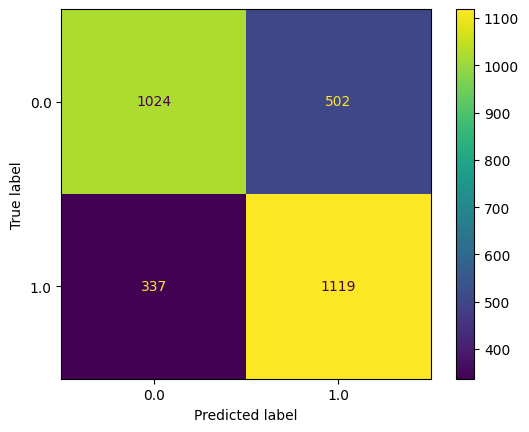

In [122]:
naive_bayes = GaussianNB()

clf3 = DecisionTreeClassifier(criterion="gini", max_depth=4, min_samples_leaf=1)

vt=voting_classifier = VotingClassifier(
            estimators=[
                ("nb", naive_bayes),
                ("knn3", knn),
                ("dt", clf3)
            ],
            voting = "hard"
)

vt.fit(X_train,y_train)
predictions = vt.predict(X_test)
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test,predictions)

In [ ]:
naive_bayes = GaussianNB()

clf3 = DecisionTreeClassifier(criterion="gini", max_depth=4, min_samples_leaf=1)

vt1=voting_classifier = VotingClassifier(
            estimators=[
                ("nb", naive_bayes),
                ("knn3", knn),
                ("dt", clf3)
            ],
            voting = "soft",
            weights=[0.167, 0.66, 0.166]
)
vt2=voting_classifier = VotingClassifier(
            estimators=[
                ("nb", naive_bayes),
                ("knn3", knn),
                ("dt", clf3)
            ],
            voting = "hard"
)
vt1.fit(X_train,y_train)
vt2.fit(X_train,y_train)

compare_classifiers_mcnemar(vt1,vt2)

Classifier 1 F1-score: 0.7321
Classifier 2 F1-score: 0.7273

McNemar Test Results:
Statistic: 56.0
P-value  : 0.32325
There is no evidence of significant difference between the classifiers.


## **Ada Boost Classifier**

In [118]:
@compute_executions_time
def execute_ada_boost_classifier_for_different_classifiers():
    parameter_list = []
    scores_list = []
    std_dev_list = []
    for nest in range(1,201,1):
        ada_boos_classifier = AdaBoostClassifier(
            n_estimators=nest
        )
        scores = cross_val_score(
            ada_boos_classifier,
            X_train,
            y_train,
            cv = SKFold,
            n_jobs=-1,
            scoring = "f1"
        )
        mean_score = scores.mean()
        std_dev_score = scores.std()
        print(f"F1-score: {mean_score:.5f} [n_estimators: {nest}]")

        parameter_list.append(nest)
        scores_list.append(mean_score)
        std_dev_list.append(std_dev_score)

    return parameter_list, scores_list, std_dev_list

F1-score: 0.71115 [n_estimators: 1]
F1-score: 0.71115 [n_estimators: 2]
F1-score: 0.73907 [n_estimators: 3]
F1-score: 0.73772 [n_estimators: 4]
F1-score: 0.73476 [n_estimators: 5]
F1-score: 0.74706 [n_estimators: 6]
F1-score: 0.74034 [n_estimators: 7]
F1-score: 0.74452 [n_estimators: 8]
F1-score: 0.74075 [n_estimators: 9]
F1-score: 0.74930 [n_estimators: 10]
F1-score: 0.74517 [n_estimators: 11]
F1-score: 0.74819 [n_estimators: 12]
F1-score: 0.74415 [n_estimators: 13]
F1-score: 0.74767 [n_estimators: 14]
F1-score: 0.74746 [n_estimators: 15]
F1-score: 0.74569 [n_estimators: 16]
F1-score: 0.74526 [n_estimators: 17]
F1-score: 0.74703 [n_estimators: 18]
F1-score: 0.74761 [n_estimators: 19]
F1-score: 0.74882 [n_estimators: 20]
F1-score: 0.74896 [n_estimators: 21]
F1-score: 0.75054 [n_estimators: 22]
F1-score: 0.75020 [n_estimators: 23]
F1-score: 0.74985 [n_estimators: 24]
F1-score: 0.75254 [n_estimators: 25]
F1-score: 0.75060 [n_estimators: 26]
F1-score: 0.75177 [n_estimators: 27]
F1-score: 

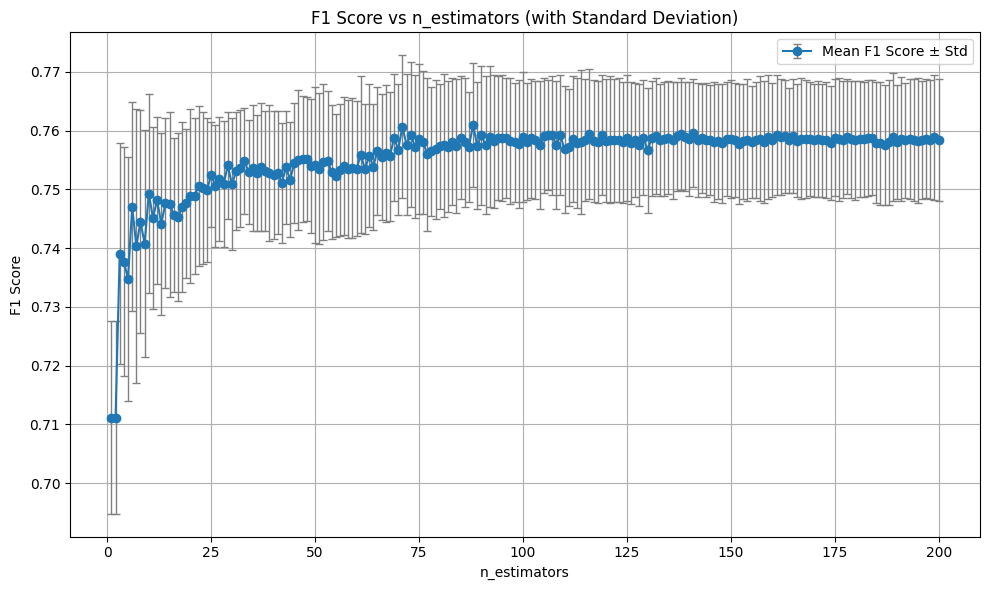

In [119]:
parameter_list, scores_list, std_dev_list = execute_ada_boost_classifier_for_different_classifiers()
plot_f1_scores_vs_parameter("n_estimators",parameter_list, scores_list, std_dev_list)

              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      1526
         1.0       0.72      0.76      0.74      1456

    accuracy                           0.74      2982
   macro avg       0.74      0.74      0.74      2982
weighted avg       0.74      0.74      0.74      2982



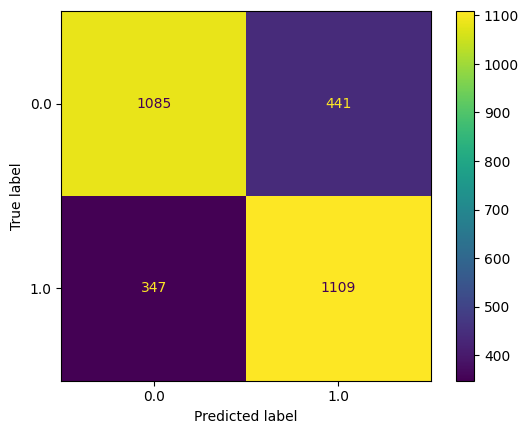

In [123]:
ada=AdaBoostClassifier(n_estimators=100)
ada.fit(X_train,y_train)
predictions = ada.predict(X_test)
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test,predictions)

In [127]:
#determinacion de mejor combinación de n_estimators y learning_rate con GridSearch

params = {
    "n_estimators" : range(1,201,10),
    "learning_rate": [0.1,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0],
    "random_state": [42]
}

clf = GridSearchCV(estimator=AdaBoostClassifier(),
            param_grid=params,
            scoring="f1",
            n_jobs=-1,
            cv=SKFold,
            )
clf.fit(X_train,y_train)

print(clf.best_params_)
best_n_est_ada = clf.best_params_["n_estimators"]
best_learning_rate_ada = clf.best_params_["learning_rate"]
print(clf.best_score_)

{'learning_rate': 0.5, 'n_estimators': 141, 'random_state': 42}
0.7612265080580098


In [131]:
ada1 = AdaBoostClassifier(n_estimators=100,random_state=42)
ada1.fit(X_train,y_train)
compare_classifiers_mcnemar(ada1,clf.best_estimator_)

Classifier 1 F1-score: 0.7379
Classifier 2 F1-score: 0.7392

McNemar Test Results:
Statistic: 59.0
P-value  : 1.00000
There is no evidence of significant difference between the classifiers.


## **Comparison between classfiers**